In [7]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from numpy.random import choice, normal

from scipy.signal import periodogram, correlate, convolve
from scipy.optimize import curve_fit

from glob import glob

from datetime import datetime

aspect_ratio = 16./9 # On HD projectors nowadays, this is the aspect ratio.
                     # so I make my figures using that ratio so they show up nicely in presentations.
BoiseState_blue = "#0033A0"
BoiseState_orange = "#D64309"

# Von Karman's constant
kappa = 0.4

In [28]:
# Grab data
heights = {"48": 62, "49": 85, "50": 108, "51": 154}
# heights = {"50": 107, "51": 128}
anemometer_names = heights.keys()
# sampling is 0.5 Hz / once every two seconds for all of them
windspeeds = {}

for key in heights.keys():
    ls = glob("Field_Experiments/Drone_Experiments/Seal Beach*%s*.csv" % key)
    
    data = np.genfromtxt(ls[0], skip_header=10, delimiter=',')

    # Convert from km/hr to cm/s
    windspeeds[key] = data[:,7]*100.
    # The data didn't record seconds for some reason.
    time = np.arange(0, 2.*(len(data[:, 7])), 2)
    
    print(windspeeds[key])

[560. 590. 630. ... 470. 500. 450.]
[590. 610. 600. ... 480. 510. 460.]
[590. 580. 600. ... 510. 530. 500.]
[680. 630. 680. ... 560. 560. 520.]


In [18]:
def calc_zstar_from_slope_and_intercept(z0, slope, intercept):
    return z0*np.exp(-intercept/slope)

def calc_ustar_from_slope(kappa, slope):
    return kappa*slope

def calc_sigma_ustar(kappa, sigma_slope):
    return kappa*sigma_slope

def calc_sigma_zstar(slope, zstar, sigma_slope, intercept, sigma_intercept, slope_intercept_corr):
    return zstar/slope*np.sqrt(sigma_intercept**2 + (intercept/slope)**2*sigma_slope**2 -\
                               2*(intercept/slope)*slope_intercept_corr)

def calculate_zstar_from_profile(heights, winds):
    x = np.log(heights/np.min(heights))
    y = winds

    popt, pcov = curve_fit(lin_fit, x, y)

    zstar = calc_zstar_from_slope_and_intercept(np.min(heights), *popt)
    return zstar

def lin_fit(x, m, b):
    return m*x + b

def wind_profile(z, ustar, zstar, kappa=0.4):
    return ustar/kappa*np.log(z/zstar)

def fit_wind_profile(z, ustar, zstar, kappa=0.4):
    x = np.log(z/np.min(z))
    
    # slope
    m = ustar/kappa
    # intercept
    b = -ustar/kappa*np.log(zstar/np.min(z))
    
    return lin_fit(x, m, b)

def retrieve_relevant_times(time, t0, sample_time):
    return ((time - t0) <= sample_time) & ((time - t0) > 0.)

def sample_wind_profile(sample_time, t0, time=time, windspeeds=windspeeds):
    """
    Return wind speeds from four height sampled over the given sample time
    
    Args:
        sample_time (float): time over which to average in seconds
        t0 (float, optional): time at which at start averages
        time (float array, optional): measured times
        windspeeds (dict of float arrays, optional): wind speed time-series referenced by anemometer name
    
    Returns:
        Wind speeds averaged for sample time from different anemometer times series, one after another
    """
    
    # Run through each height, assuming the first one in windspeeds is the lowest and on up
    cur_t0 = t0
    
    averaged_heights = np.array([])
    averaged_windspeeds = np.array([])
    std_windspeeds = np.array([])
    for key in windspeeds.keys():
        ind = retrieve_relevant_times(time, t0, sample_time) 
        
        averaged_windspeeds = np.append(np.mean(windspeeds[key][ind]), averaged_windspeeds)
        averaged_heights = np.append(heights[key], averaged_heights)
        std_windspeeds = np.append(np.std(windspeeds[key][ind])/(np.sqrt(len(windspeeds[key][ind])) - 1.),
                                   std_windspeeds)
        
        cur_t0 += sample_time
        
    return averaged_heights, averaged_windspeeds, std_windspeeds

def interpolate_to_t0(time, windspeeds, t0):
    coeffs = np.polyfit(time, windspeeds, 1)
    return np.polyval(coeffs, t0)

def linear_fit_sample_wind_profile(sample_time, t0, time=time, windspeeds=windspeeds):
    """
    Fits straight line to winds over time and returns wind interpolated to t0
    
    Args:
        sample_time (float): time over which to average in seconds
        t0 (float, optional): time at which at start averages
        time (float array, optional): measured times
        windspeeds (dict of float arrays, optional): wind speed time-series referenced by anemometer name
    
    Returns:
        Wind speeds averaged for sample time from different anemometer times series, one after another
    """
    
    # Run through each height, assuming the first one in windspeeds is the lowest and on up
    cur_t0 = t0
    
    averaged_heights = np.array([])
    interpolated_windspeeds = np.array([])
    sigma_windspeeds = np.array([])
    for key in windspeeds.keys():
        ind = retrieve_relevant_times(time, t0, sample_time)
        
        averaged_heights = np.append(heights[key], averaged_heights)
                   
        interpolated_windspeeds = np.append(interpolate_to_t0(time[ind], windspeeds[key][ind], t0), 
                                            interpolated_windspeeds)
        sigma_windspeeds = np.append(np.std(windspeeds[key][ind])/(np.sqrt(len(windspeeds[key][ind])) - 1.),
                                   sigma_windspeeds)
        
        cur_t0 += sample_time
        
    return averaged_heights, interpolated_windspeeds, sigma_windspeeds

def compare_moving_average(time, data, sample_time, init_t0=0, quantiles=[0.16, 0.5, 0.84]):
    t0 = init_t0
    
    lowers = np.array([])
    medians = np.array([])
    uppers = np.array([])
    sample_times = np.array([])

    t0 += sample_time
    while(np.max(time) - t0 > sample_time):
    
        sample_times = np.append(t0, sample_times)

        ind = retrieve_relevant_times(time, t0, sample_time)
        cur_lower, cur_median, cur_upper = np.quantile(data[ind], quantiles)

        lowers = np.append(cur_lower, lowers)
        medians = np.append(cur_median, medians)
        uppers = np.append(cur_upper, uppers)

        t0 += sample_time

    return sample_times, lowers, medians, uppers

def compare_growing_average(time, data, init_sample_time, 
                            sampling_interval = 2, init_t0=0, quantiles=[0.16, 0.5, 0.84]):
    t0 = init_t0
    averaging_window = init_sample_time
    
    lowers = np.array([])
    medians = np.array([])
    uppers = np.array([])
    averaging_windows = np.array([])

    while(averaging_window < (np.max(time))):
    
        averaging_windows = np.append(averaging_window, averaging_windows)

        ind = retrieve_relevant_times(time, t0, averaging_window)
        cur_lower, cur_median, cur_upper = np.quantile(data[ind], quantiles)

        lowers = np.append(cur_lower, lowers)
        medians = np.append(cur_median, medians)
        uppers = np.append(cur_upper, uppers)

        averaging_window += sampling_interval

    return averaging_windows, lowers, medians, uppers

26.084137402219415 0.013830521185622186
2.9113840745472235 0.01232390676380952


Text(0.5, 0, 'Average Wind Speed (${\\rm cm\\ s^{-1}}$)')

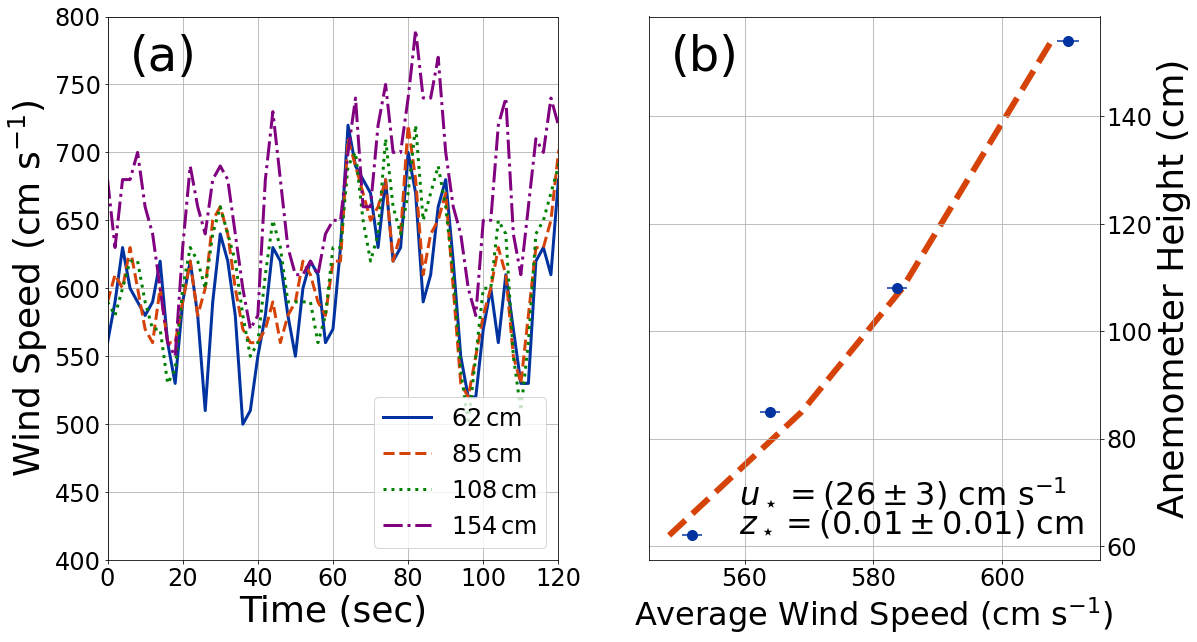

In [31]:
fig = plt.figure(figsize=(10*aspect_ratio, 10))
ax1 = fig.add_subplot(121)

heights = {"48": 62, "49": 85, "50": 108, "51": 154}
# heights = {"50": 107, "51": 128}
anemometer_names = heights.keys()

# Set my own colors
color = iter([BoiseState_blue, BoiseState_orange, 'green', 'purple'])
linestyles = iter(['-', '--', ':', '-.'])

# sampling is 0.5 Hz / once every two seconds for all of them
windspeeds = {}
means = {}
stds = {}

sample_time = 60.
t0 = 0.

for key in heights.keys():
# for key in ["48"]:
    c = next(color)
    linestyle = next(linestyles)
    
    ls = glob("Field_Experiments/Drone_Experiments/Seal Beach*%s*.csv" % key)
    
    data = np.genfromtxt(ls[0], skip_header=10, delimiter=',')

    # Convert from m/s to cm/s
    windspeeds[key] = data[:,7]*100.
    
    means[key] = np.mean(data[:, 7]*100.)
    
    # error on the mean
    stds[key] = np.std(data[:, 7]*100.)/np.sqrt(len(data[:, 7]))
    
    # The data didn't record seconds for some reason.
    time = np.arange(0, 2.*(len(data[:, 7])), 2)
    ax1.plot(time, data[:, 7]*100., lw=3, color=c, ls=linestyle, label=r'$%s\,{\rm cm}$' % heights[key])

    # Add mean illustration
#     ind = retrieve_relevant_times(time, t0, sample_time)
#     mean_windspeed = np.mean(windspeeds[key][ind])
#     ax1.axhline(mean_windspeed, lw=6, alpha=0.5, color=c, ls=linestyle)
    
    t0 += sample_time
    
ax1.set_xlim([0, 120])
ax1.set_ylim([400, 800])
ax1.grid(True)
ax1.tick_params(labelsize=24)
ax1.set_xlabel("Time (sec)", fontsize=36)
ax1.set_ylabel(r'Wind Speed (${\rm cm\ s^{-1}}$)', fontsize=36)
ax1.text(0.05, 0.90, "(a)", fontsize=48, transform=ax1.transAxes)
ax1.legend(loc='lower right', fontsize=24)

#### Estimating Roughness Scale ####

ax2 = fig.add_subplot(122)

x = np.array(list(heights.values()))
y = np.array(list(means.values()))
yerr = np.array(list(stds.values()))

# Law-of-the-Wall fit
log_z = np.log(x/np.min(x))
popt, pcov = curve_fit(lin_fit, log_z, y, sigma=yerr)
unc = np.sqrt(np.diag(pcov))
ustar = calc_ustar_from_slope(kappa, popt[0])
sigma_ustar = calc_sigma_ustar(kappa, unc[0])
zstar = calc_zstar_from_slope_and_intercept(np.min(x), popt[0], popt[1])
sigma_zstar = calc_sigma_zstar(popt[0], zstar, unc[0], popt[1], unc[1], np.abs(pcov[0,1]))

saved_zstar = zstar
saved_sigma_zstar = sigma_zstar

print(ustar, zstar)
print(sigma_ustar, sigma_zstar)

ax2.errorbar(y, x, xerr=yerr, ls='', marker='o', markersize=10, color=BoiseState_blue)
ax2.plot(np.polyval(popt, log_z), x, lw=6, color=BoiseState_orange, ls='--', zorder=-1)
ax2.text(0.05, 0.90, "(b)", fontsize=48, transform=ax2.transAxes)
ax2.text(0.2, 0.1, r'$u_\star = \left( %.0f\pm%.0f \right)\ {\rm cm\ s^{-1}}$' % (ustar, sigma_ustar), 
         fontsize=32, transform=ax2.transAxes)
ax2.text(0.2, 0.05, r'$z_\star = \left( %.2f\pm%.2f \right)\ {\rm cm}$' % (zstar, sigma_zstar), 
         fontsize=32, transform=ax2.transAxes)

ax2.grid(True)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.tick_params(labelsize=24)
ax2.set_ylabel("Anemometer Height (cm)", fontsize=36)
ax2.set_xlabel(r'Average Wind Speed (${\rm cm\ s^{-1}}$)', fontsize=32)

# plt.savefig("Alamosa_Parking_Lot_Windspeeds.jpg", dpi=300, bbox_inches="tight")
plt.savefig("Seal_Beach_Windspeeds.jpg", dpi=300, bbox_inches="tight")

In [58]:
x = np.array(list(heights.values()))
y = np.array(list(means.values()))
yerr = np.array(list(stds.values()))

wind_profile_popt, wind_profile_pcov = curve_fit(wind_profile, x, y, sigma=yerr, p0=[50., 0.1])
wind_profile_unc = np.sqrt(np.diag(wind_profile_pcov))
print(wind_profile_unc)

# Can I correctly propagate uncertainties?
sigma_ustar = calc_sigma_ustar(0.4, unc[0])
sigma_zstar = calc_sigma_zstar(popt[0], zstar, unc[0], popt[1], unc[1], pcov[0,1])
print(sigma_ustar, sigma_zstar)

[4.69558929 0.09281762]
16.725935910721596 3.2247912392422755


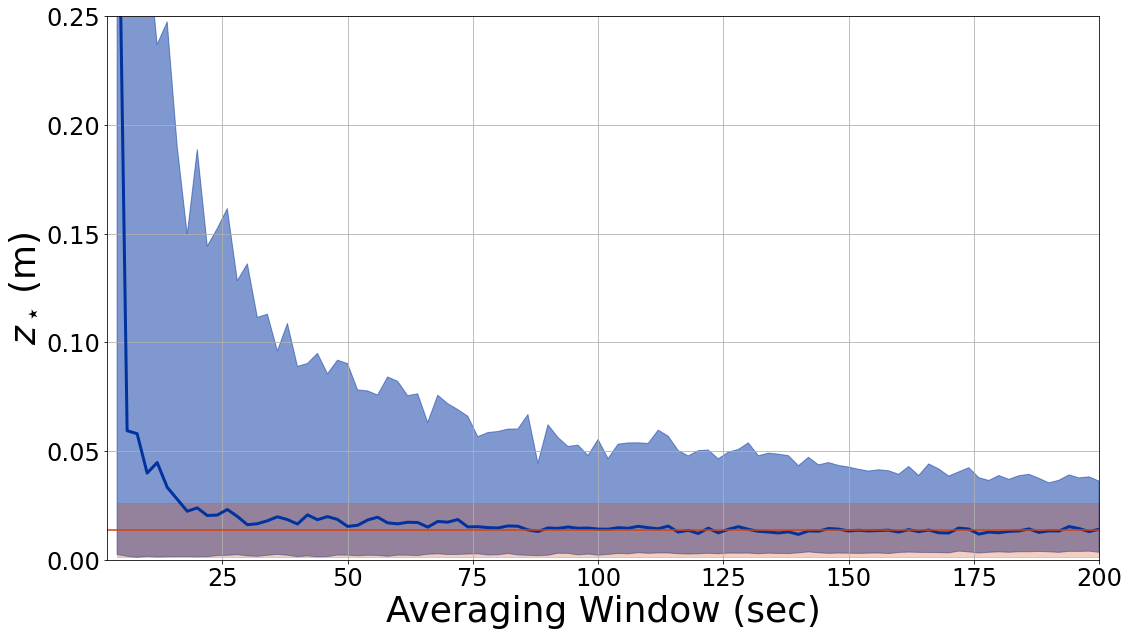

In [36]:
fig = plt.figure(figsize=(10*16/9, 10))
ax = fig.add_subplot(111)
# sample_times = 2.**(np.linspace(1, 8, 8))
sample_times = np.arange(4, 202, 2)
# sample_times = np.array([1000])
# print(sample_times)
num_tries = 1000

median_quantile = 0.5
upper_quantile = 0.84
lower_quantile = 0.16

# saved_sample_times = np.array([])
# zstars = np.array([])
# zstars_sigma = np.array([])
# lower_sigmas = np.array([])
# upper_sigmas = np.array([])

# for i in range(len(sample_times)):
#     cur_saved_sample_times = np.array([])
#     cur_zstars = np.array([])
    
#     for j in range(num_tries):
        
#         # Make sure there is plenty of time at the end
#         t0 = choice(time[time < time[-1] - len(heights)*sample_times[i]])
#         averaged_heights, averaged_windspeeds, std_windspeeds = sample_wind_profile(sample_times[i], t0)
    
#         # How about we toss any profile that doesn't increase with altitude?
#         # https://stackoverflow.com/questions/3755136/pythonic-way-to-check-if-a-list-is-sorted-or-not
#         if(all(averaged_windspeeds[i+1] <= averaged_windspeeds[i] for i in range(len(averaged_windspeeds) - 1))):
    
#             x = np.log(averaged_heights/np.min(averaged_heights))
#             y = averaged_windspeeds
#             popt, pcov = curve_fit(lin_fit, x, y, sigma=std_windspeeds)
#             unc = np.sqrt(np.diag(pcov))

#             # If the slope is negative, then we want zstar to be negative.    
#             zstar = calc_zstar_from_slope_and_intercept(np.min(averaged_heights), *popt)*np.sign(popt[0])

#             cur_zstars = np.append(zstar, cur_zstars)
#             cur_saved_sample_times = np.append(sample_times[i], cur_saved_sample_times)

#     zstars = np.append(np.quantile(cur_zstars, [median_quantile]), zstars)
#     lower_sigma, upper_sigma = np.quantile(cur_zstars, [lower_quantile, upper_quantile]) -\
#         np.quantile(cur_zstars, [median_quantile])
#     lower_sigmas = np.append(-lower_sigma, lower_sigmas)
#     upper_sigmas = np.append(upper_sigma, upper_sigmas)
    
#     saved_sample_times = np.append(sample_times[i], saved_sample_times)

ax.plot(saved_sample_times, zstars, color=BoiseState_blue, lw=3)
ax.fill_between(saved_sample_times, zstars - lower_sigmas, 
                zstars + upper_sigmas, color=BoiseState_blue, alpha=0.5)

# print(saved_sample_times)
# print(zstars)
ax.axhline(saved_zstar, color=BoiseState_orange)
ax.fill_between(saved_sample_times, saved_zstar + saved_sigma_zstar, saved_zstar - saved_sigma_zstar, 
                color=BoiseState_orange, alpha=0.25)

ax.set_ylim([0, 0.25])
ax.set_xlim([2, 200])
ax.grid(True)

ax.set_xlabel("Averaging Window (sec)", fontsize=36)
ax.set_ylabel(r'$z_\star\, \left({\rm m}\right)$', fontsize=36)
ax.tick_params(labelsize=24)

fig.savefig("synthetic_terrestrial_wind_profile.jpg", dpi=300, bbox_inches="tight")